### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/home/opc/Retina/BRSET/'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images/')
LABEL = 'diabetes'
TEST_SIZE = 0.3
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'image_id'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = None # [0.485, 0.456, 0.406]
NORM_STD = None # [0.229, 0.224, 0.225]

BACKBONE = 'convnextv2_large'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df.head()

loading csv file in /home/opc/Retina/BRSET//labels.csv


image_id  patient_id    camera  patient_age comorbidities diabetes_time_y  \
0  img00001           1  Canon CR         48.0     diabetes1              12   
1  img00002           1  Canon CR         48.0     diabetes1              12   
2  img00003           2  Canon CR         18.0     diabetes1               7   
3  img00004           2  Canon CR         18.0     diabetes1               7   
4  img00005           3  Canon CR         22.0     diabetes1              11   

  insuline  patient_sex  exam_eye diabetes  ... vascular_occlusion  \
0      yes            1         1      yes  ...                  0   
1      yes            1         2      yes  ...                  0   
2      yes            2         1      yes  ...                  0   
3      yes            2         2      yes  ...                  0   
4      yes            1         1      yes  ...                  0   

  hypertensive_retinopathy  drusens  hemorrhage  retinal_detachment  \
0                        0        0           0                   0   
1                        0        0           0                   0   
2                        0        0           0                   0   
3                        0        0           0                   0   
4                        0        0           0                   0   

   myopic_fundus  increased_cup_disc  other   quality  normality  
0              0                   1      0  Adequate   abnormal  
1              0                   1      0  Adequate   abnormal  
2              0                   0      0  Adequate     normal  
3              0                   0      0  Adequate     normal  
4              0                   0      0  Adequate     normal  

[5 rows x 35 columns]

In [4]:
# Map values to categories
df[LABEL] = df[LABEL].apply(lambda x: 'True' if x == 'yes' else 'False')

Train data shape: (11386, 35)
Test data shape: (4880, 35)


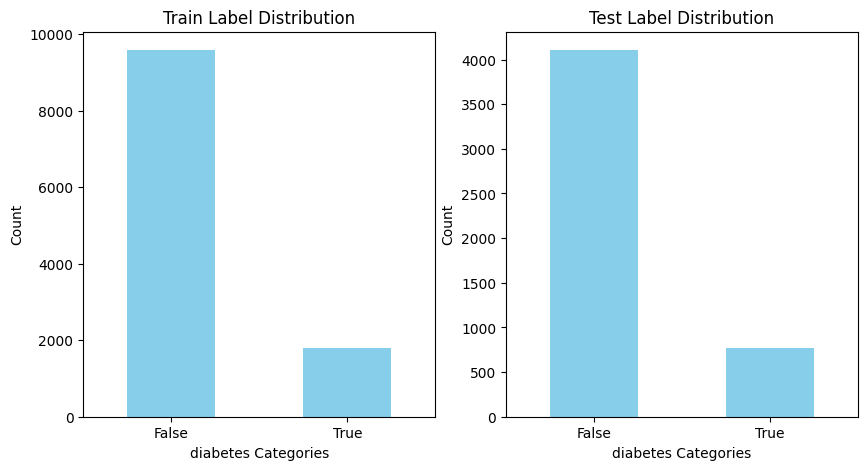

Getting validation set...
Train data shape: (3904, 35)
Test data shape: (976, 35)


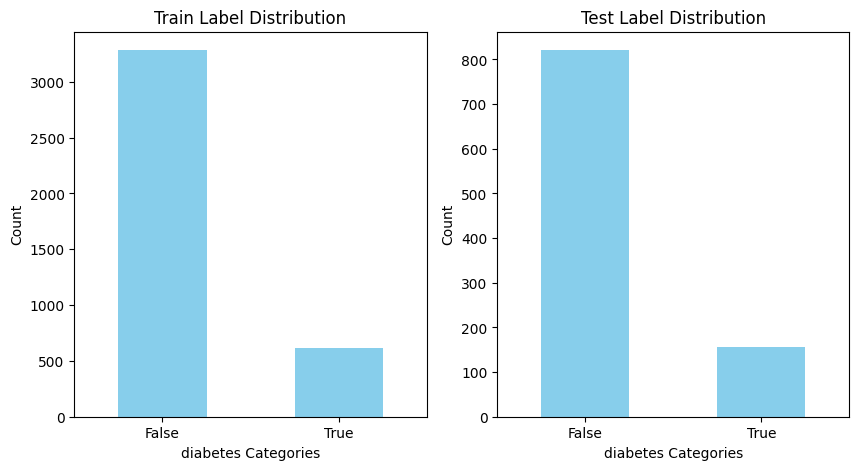

In [5]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_test, df_val = split_data(df_test, LABEL, 0.20)

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

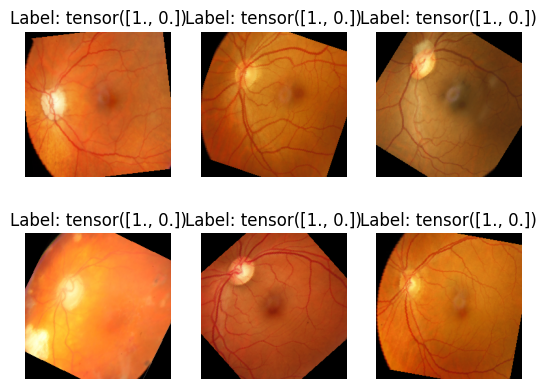

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using 2 GPUs!


### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone='convnextv2_binary_{LABEL}')

100%|██████████| 61/61 [00:17<00:00,  3.39it/s]


Epoch 1, Train Loss: 0.6172325723501069, Val Loss: 0.5145955786841815, F1 Score: 0.6000779536175975


100%|██████████| 61/61 [00:18<00:00,  3.27it/s]


Epoch 2, Train Loss: 0.5670354659721423, Val Loss: 0.505381775684044, F1 Score: 0.602855502571157


100%|██████████| 61/61 [00:18<00:00,  3.31it/s]


Epoch 3, Train Loss: 0.5664163736019576, Val Loss: 0.5067470850514584, F1 Score: 0.5731291510774674


100%|██████████| 61/61 [00:18<00:00,  3.33it/s]


Epoch 4, Train Loss: 0.55134842366901, Val Loss: 0.5677340072197993, F1 Score: 0.589693470207575


100%|██████████| 61/61 [00:17<00:00,  3.40it/s]


Epoch 5, Train Loss: 0.527947663340006, Val Loss: 0.5022285079858342, F1 Score: 0.5796297795882346


100%|██████████| 61/61 [00:18<00:00,  3.27it/s]


Epoch 6, Train Loss: 0.5332393999514955, Val Loss: 0.45093659055037577, F1 Score: 0.659217877094972


100%|██████████| 61/61 [00:18<00:00,  3.29it/s]


Epoch 7, Train Loss: 0.5113106765732002, Val Loss: 0.442122435716332, F1 Score: 0.6860467764341509


100%|██████████| 61/61 [00:18<00:00,  3.31it/s]


Epoch 8, Train Loss: 0.5238318743205137, Val Loss: 0.48609861413963507, F1 Score: 0.6421949061533698


100%|██████████| 61/61 [00:18<00:00,  3.27it/s]


Epoch 9, Train Loss: 0.5005005606021105, Val Loss: 0.4316860332352216, F1 Score: 0.6565856734298647


100%|██████████| 61/61 [00:17<00:00,  3.40it/s]


Epoch 10, Train Loss: 0.49151173049814245, Val Loss: 0.5410731674217787, F1 Score: 0.7004397159736966


100%|██████████| 61/61 [00:18<00:00,  3.30it/s]


Epoch 11, Train Loss: 0.48323098352451005, Val Loss: 0.4742844890131325, F1 Score: 0.7169120928157073


100%|██████████| 61/61 [00:18<00:00,  3.30it/s]


Epoch 12, Train Loss: 0.46756786576817544, Val Loss: 0.43534423740672284, F1 Score: 0.7087355939920871


100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


Epoch 13, Train Loss: 0.46318636579292544, Val Loss: 0.4635587095237169, F1 Score: 0.678277408223191


100%|██████████| 61/61 [00:19<00:00,  3.19it/s]


Epoch 14, Train Loss: 0.45813615589789797, Val Loss: 0.496222298042696, F1 Score: 0.6675084511762686


100%|██████████| 61/61 [00:18<00:00,  3.28it/s]


Epoch 15, Train Loss: 0.43944429054730727, Val Loss: 0.4653201837275849, F1 Score: 0.6485862543683152


100%|██████████| 61/61 [00:18<00:00,  3.23it/s]


Epoch 16, Train Loss: 0.43680875507717054, Val Loss: 0.41392614521452636, F1 Score: 0.7368512277323063


100%|██████████| 61/61 [00:18<00:00,  3.25it/s]


Epoch 17, Train Loss: 0.41285566155788267, Val Loss: 0.42813644045200505, F1 Score: 0.6833518724508714


100%|██████████| 61/61 [00:18<00:00,  3.26it/s]


Epoch 18, Train Loss: 0.39698139974700936, Val Loss: 0.46781008702809695, F1 Score: 0.649465708745996


100%|██████████| 61/61 [00:18<00:00,  3.21it/s]


Epoch 19, Train Loss: 0.38991668643534516, Val Loss: 0.4303634479397633, F1 Score: 0.7047092069393586


100%|██████████| 61/61 [00:18<00:00,  3.31it/s]


Epoch 20, Train Loss: 0.36809637683203045, Val Loss: 0.47646767316294497, F1 Score: 0.7046112501129005


100%|██████████| 61/61 [00:18<00:00,  3.22it/s]


Epoch 21, Train Loss: 0.3535859661825587, Val Loss: 0.48823969530277567, F1 Score: 0.6992585459797785


100%|██████████| 61/61 [00:18<00:00,  3.25it/s]


Epoch 22, Train Loss: 0.34323558112962194, Val Loss: 0.48106930050693575, F1 Score: 0.6841329297893379


100%|██████████| 61/61 [00:18<00:00,  3.33it/s]


Epoch 23, Train Loss: 0.319043700473404, Val Loss: 0.4729927194411637, F1 Score: 0.6975519057948558
Early stopping triggered.


### Test

100%|██████████| 244/244 [01:08<00:00,  3.54it/s]


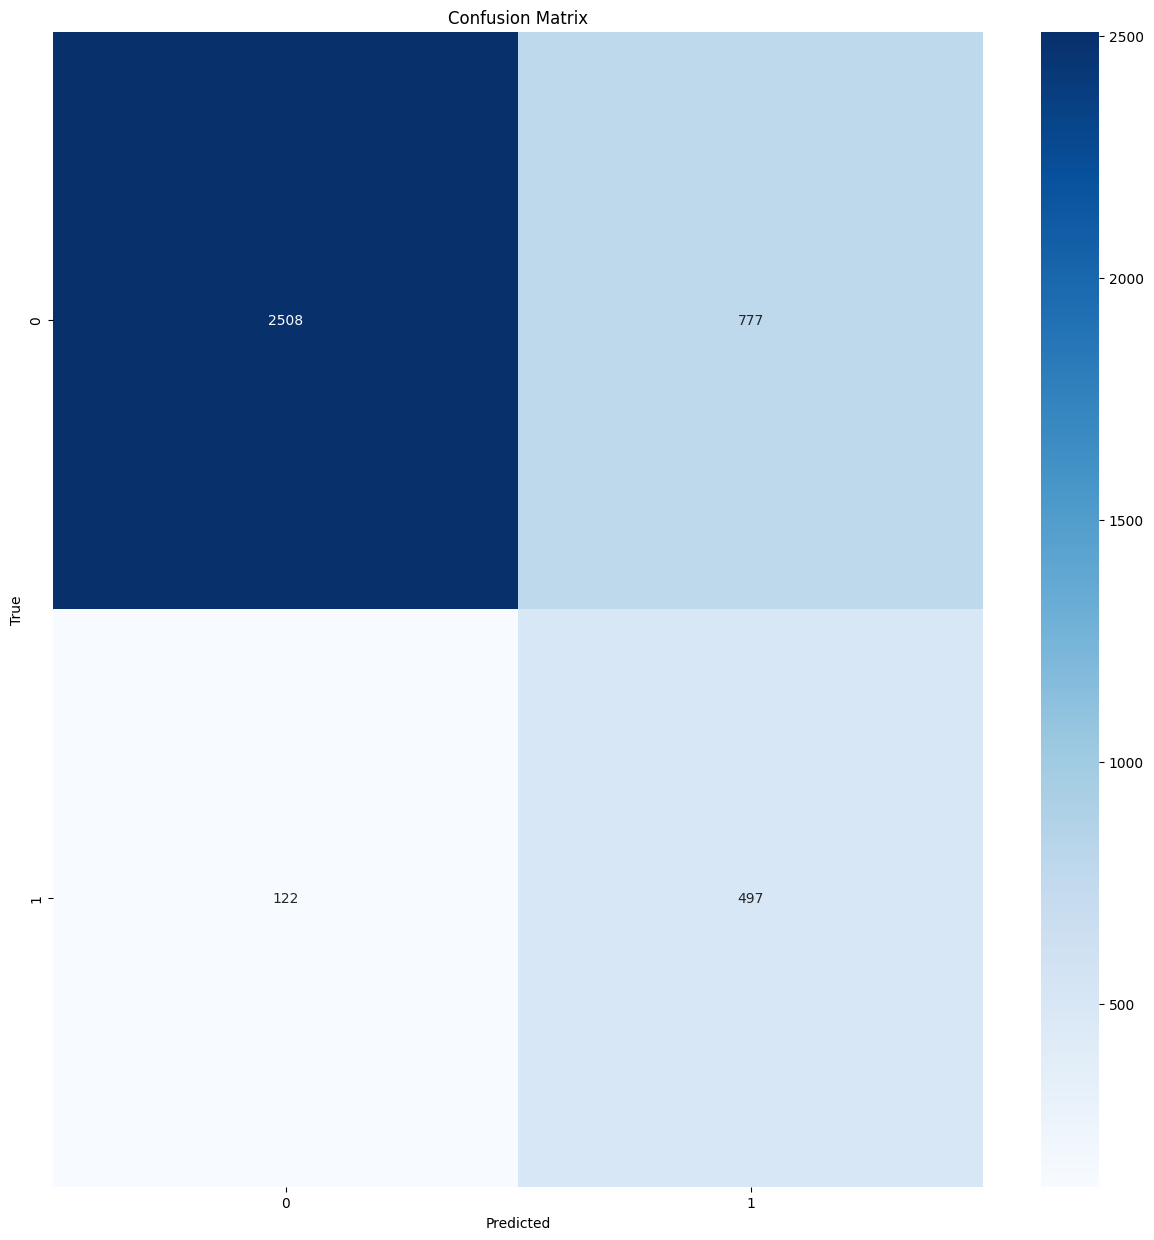

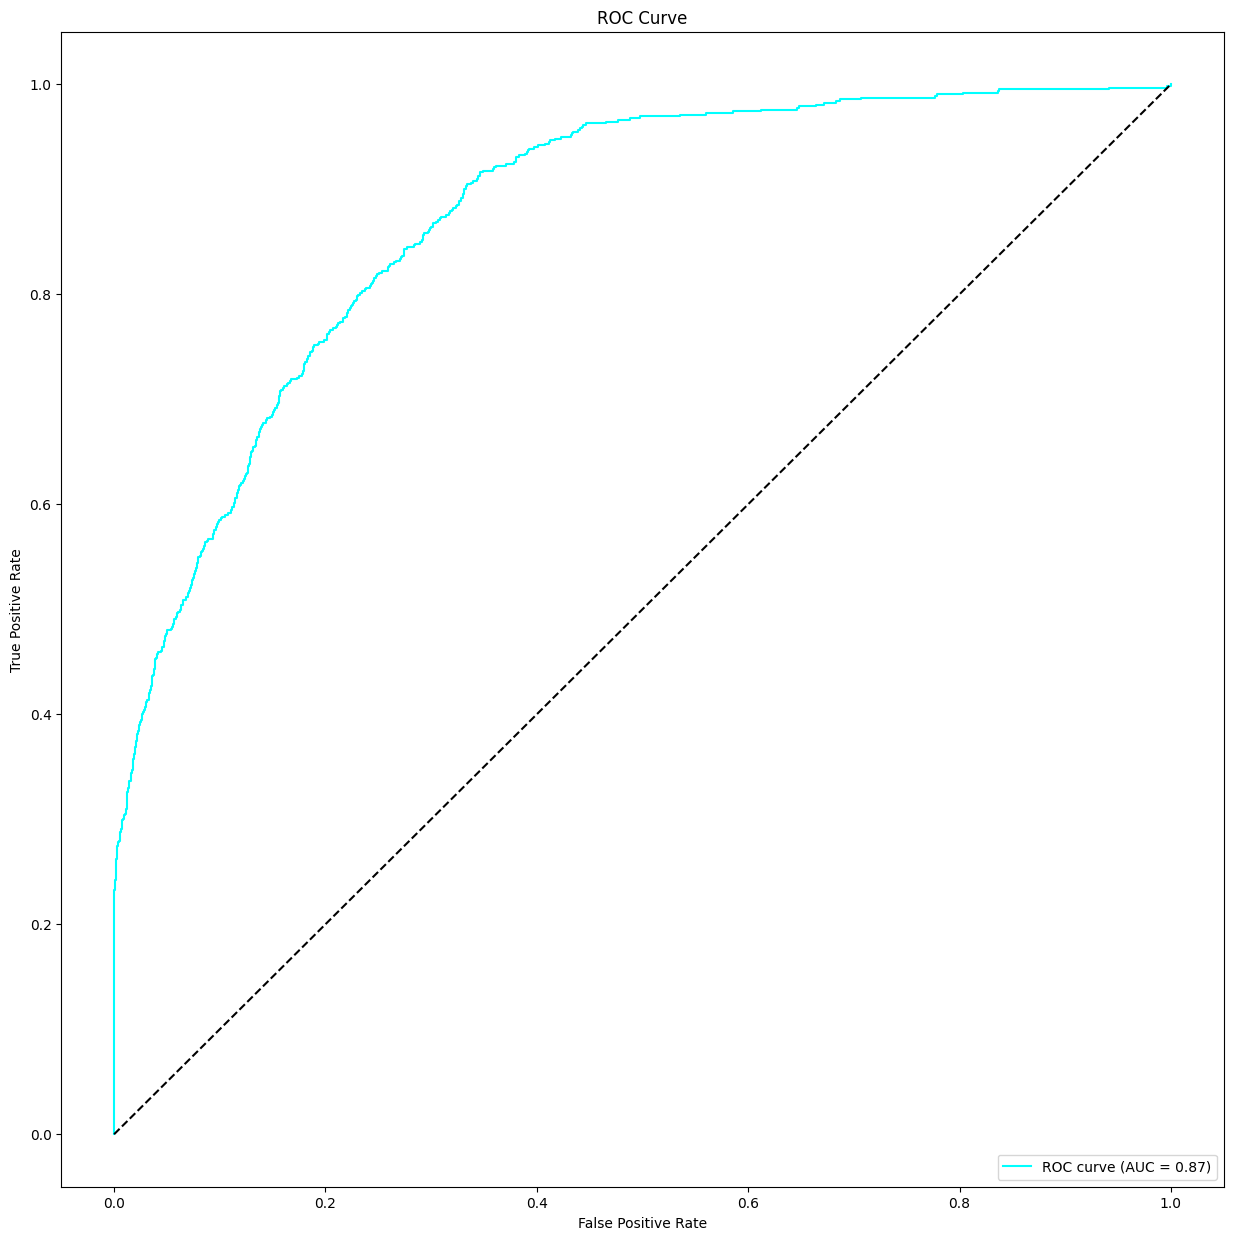

              precision    recall  f1-score   support

           0       0.95      0.76      0.85      3285
           1       0.39      0.80      0.53       619

    accuracy                           0.77      3904
   macro avg       0.67      0.78      0.69      3904
weighted avg       0.86      0.77      0.80      3904

##################################################  Saliency Maps  ##################################################

Class 0:


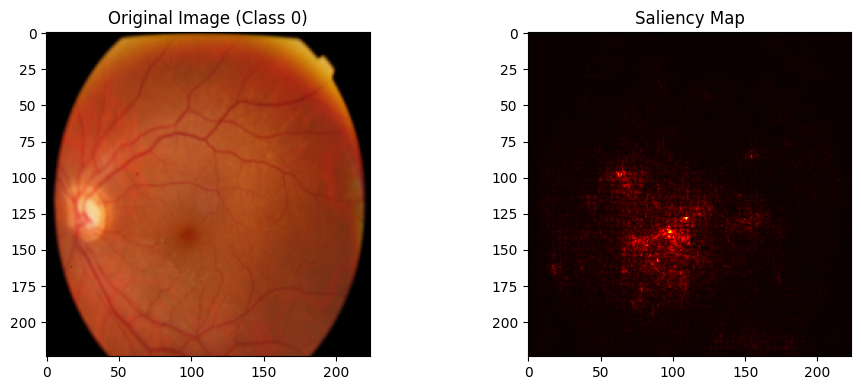

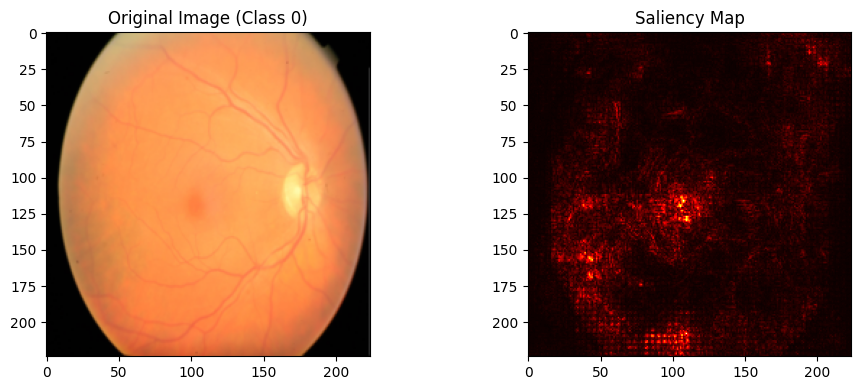

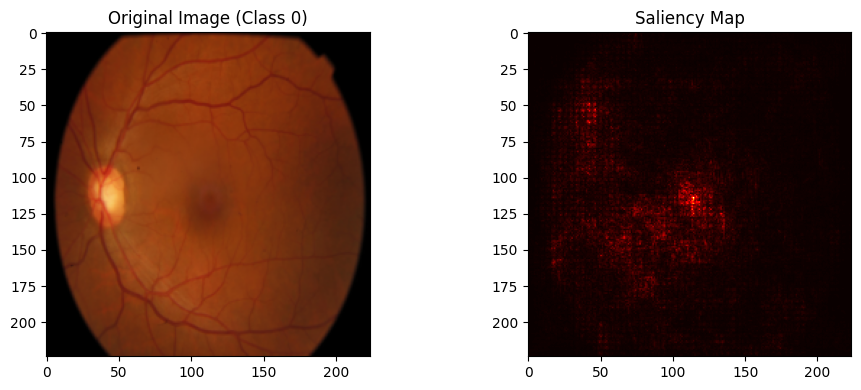

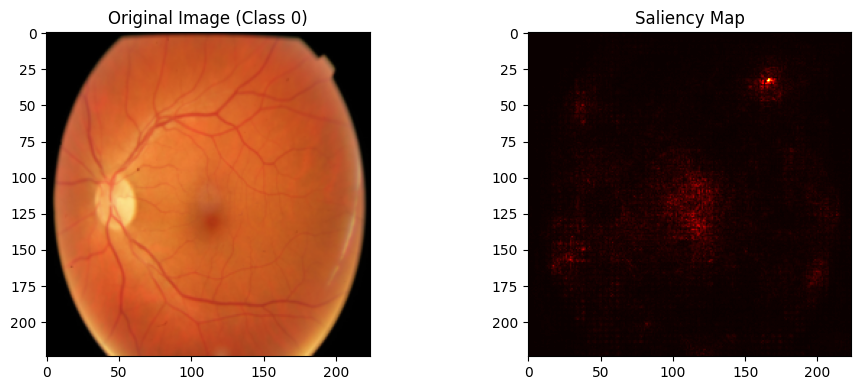

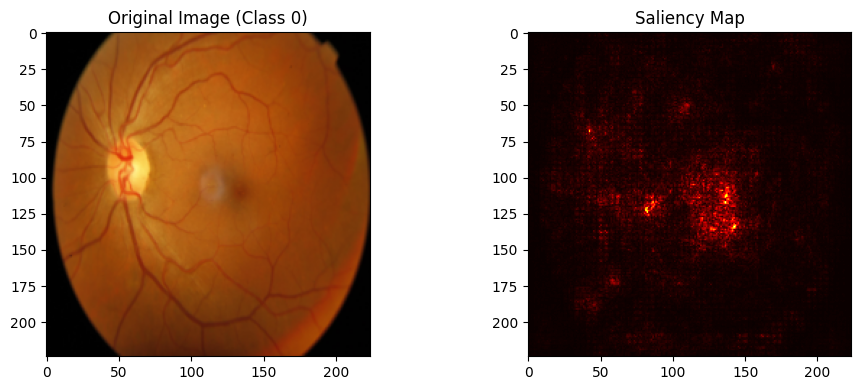

Class 1:


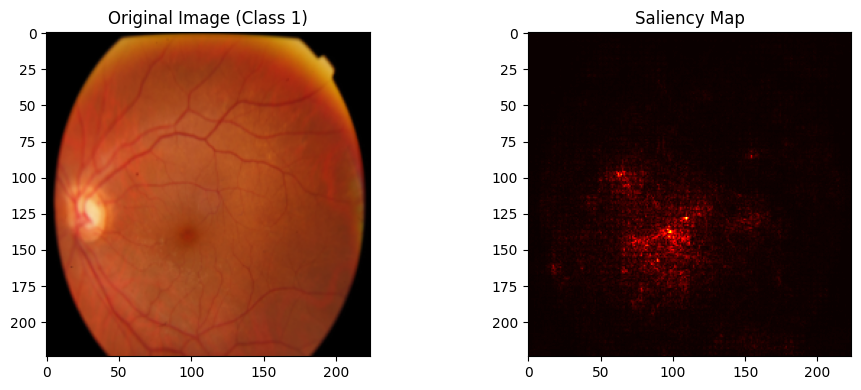

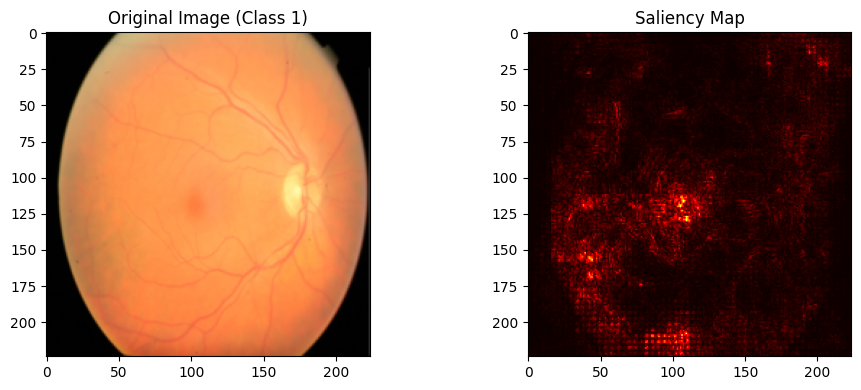

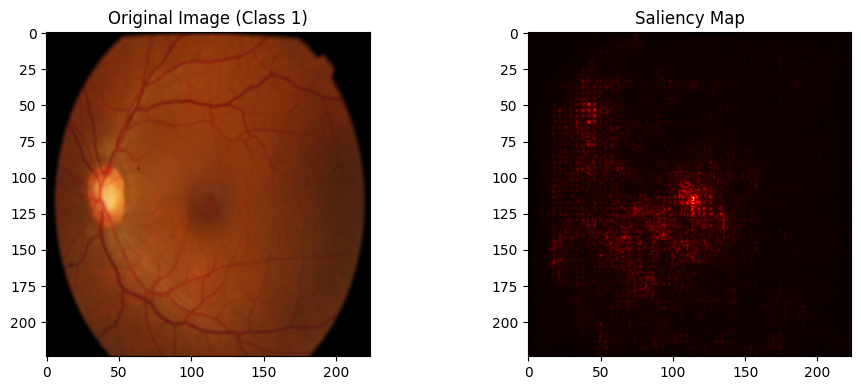

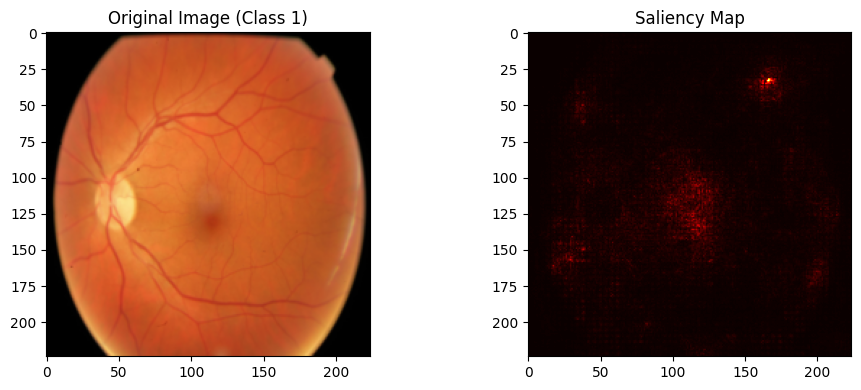

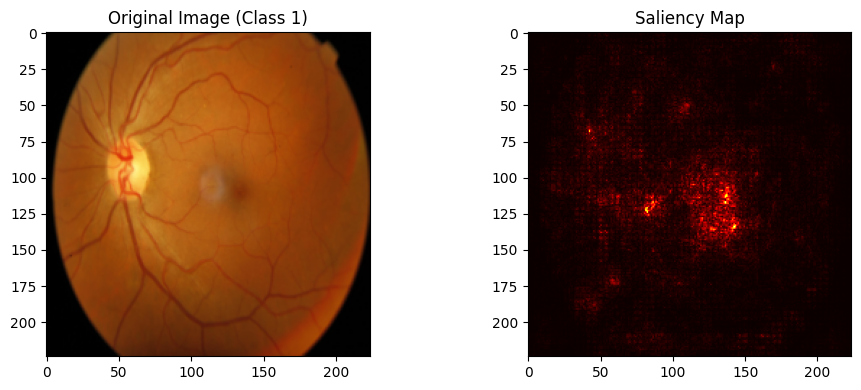

In [13]:
test(model, test_dataloader, saliency=True, device=device)

### Image quality assessment

In [14]:
# Good quality images
adequate_df = df_test[df_test['quality'] == 'Adequate']

# Bad quality images
inadequate_df = df_test[df_test['quality'] == 'Inadequate']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 214/214 [01:00<00:00,  3.55it/s]


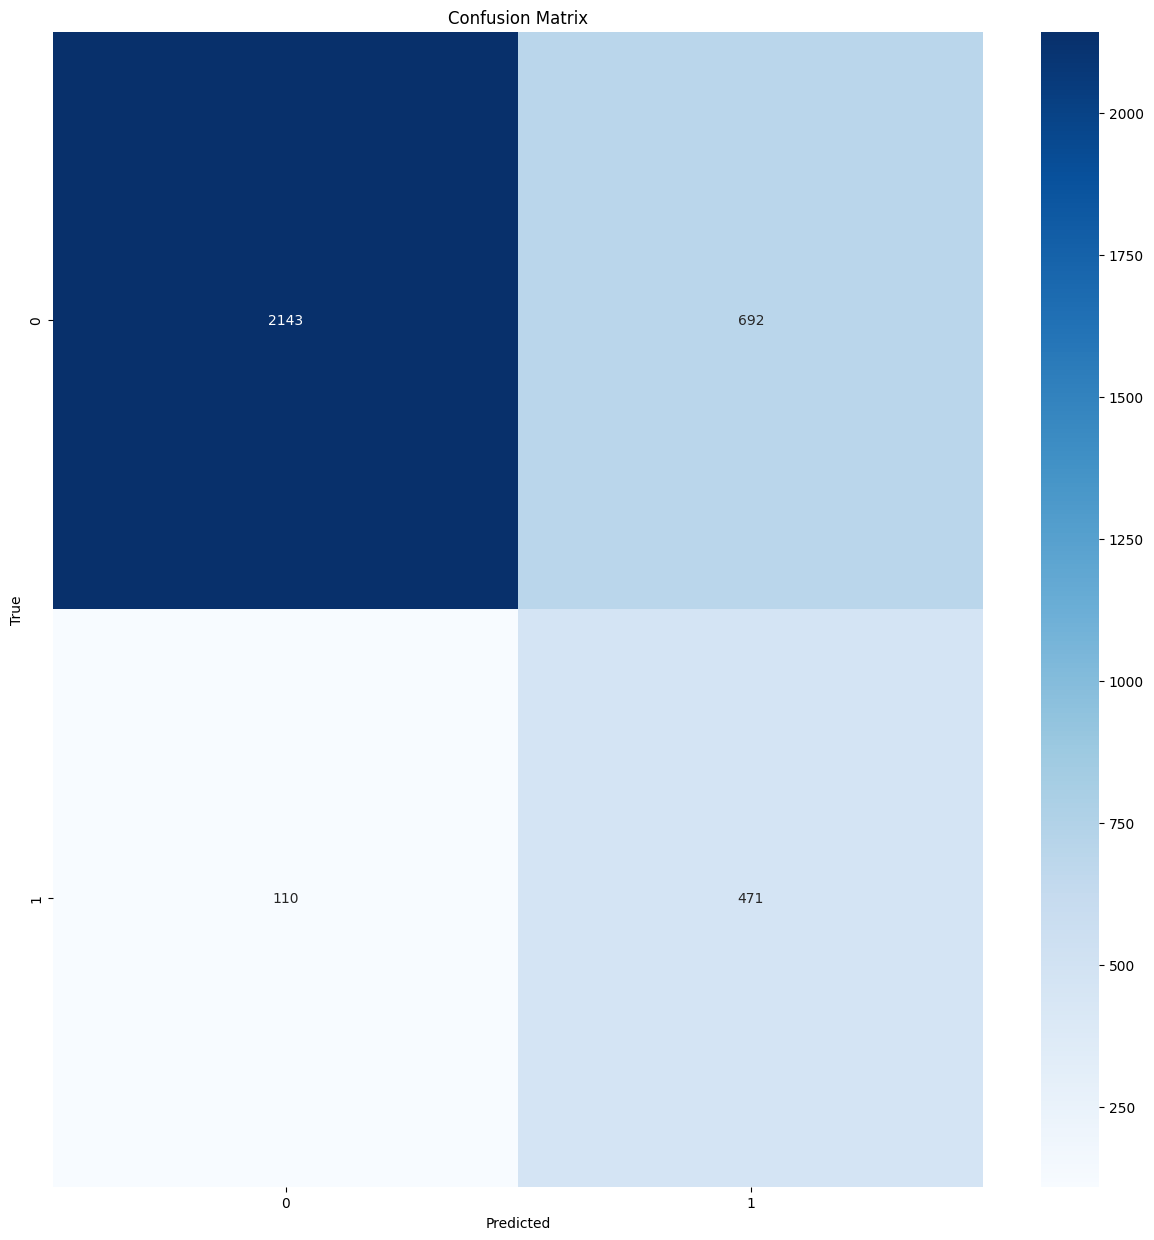

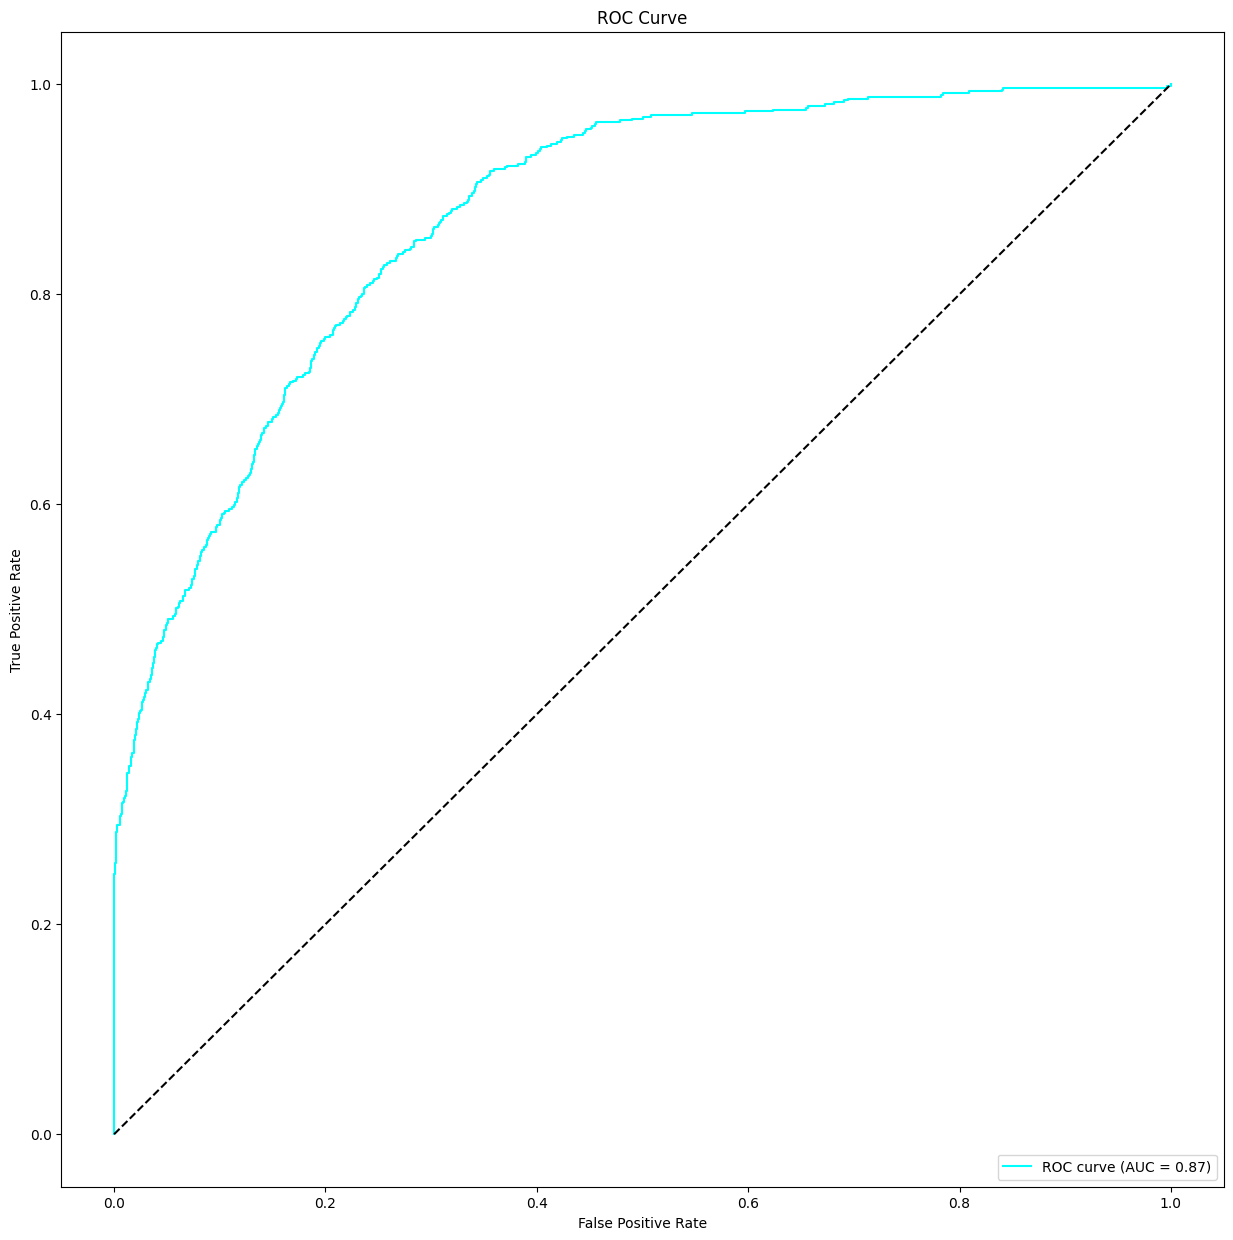

              precision    recall  f1-score   support

           0       0.95      0.76      0.84      2835
           1       0.40      0.81      0.54       581

    accuracy                           0.77      3416
   macro avg       0.68      0.78      0.69      3416
weighted avg       0.86      0.77      0.79      3416

##################################################  Saliency Maps  ##################################################

Class 0:


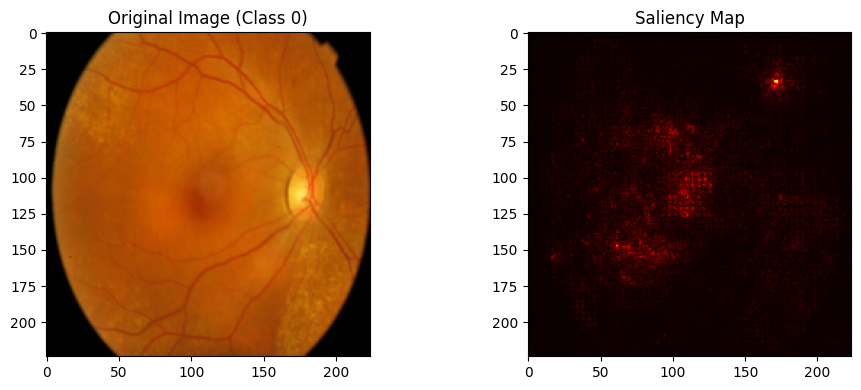

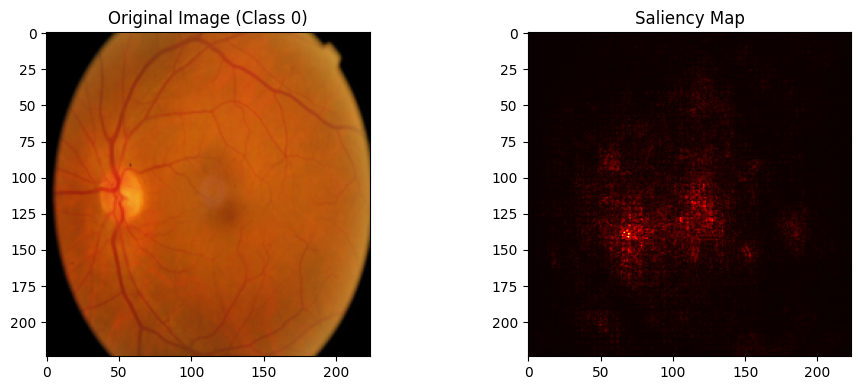

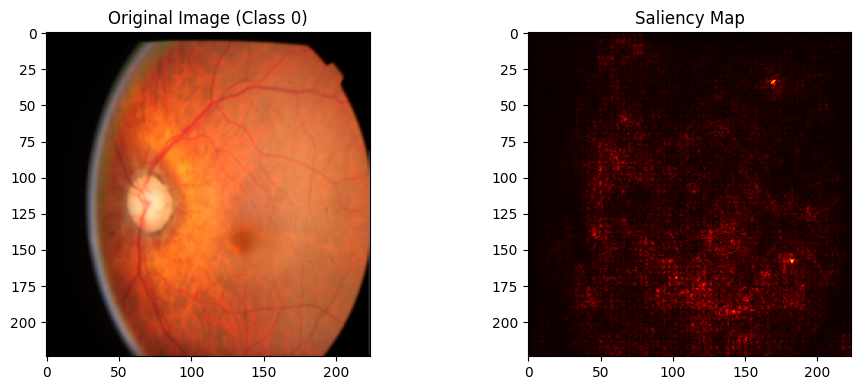

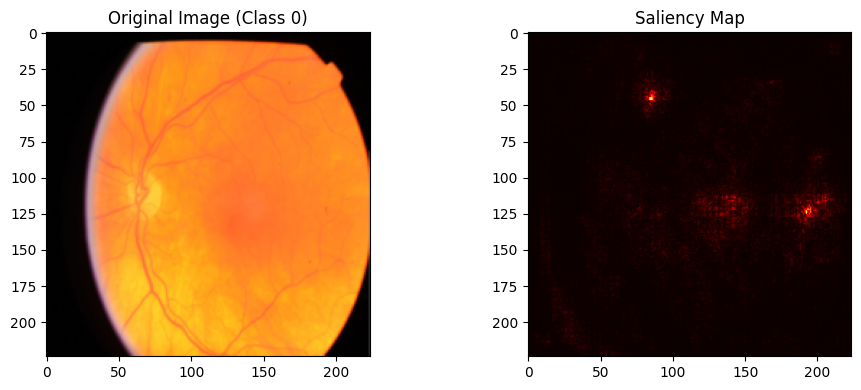

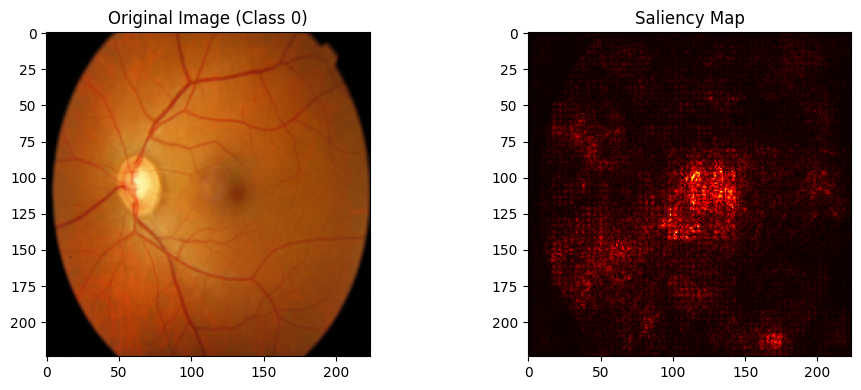

Class 1:


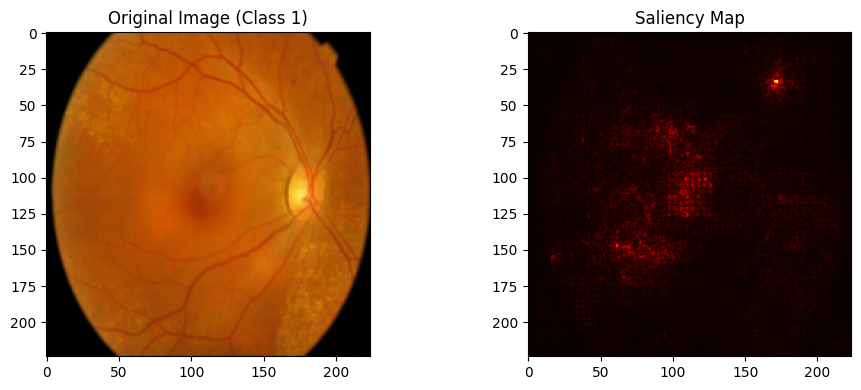

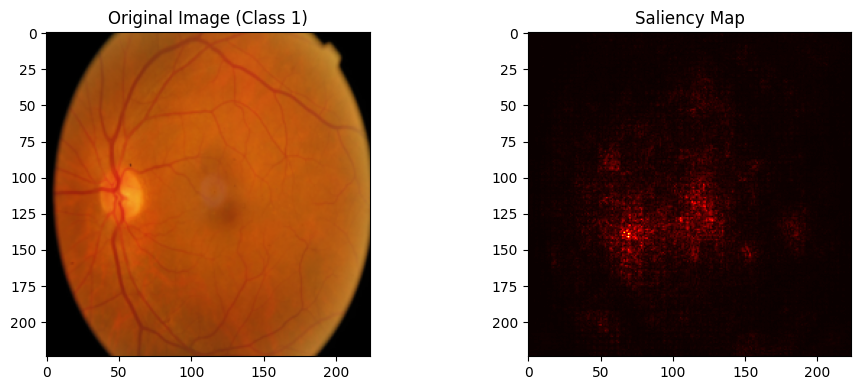

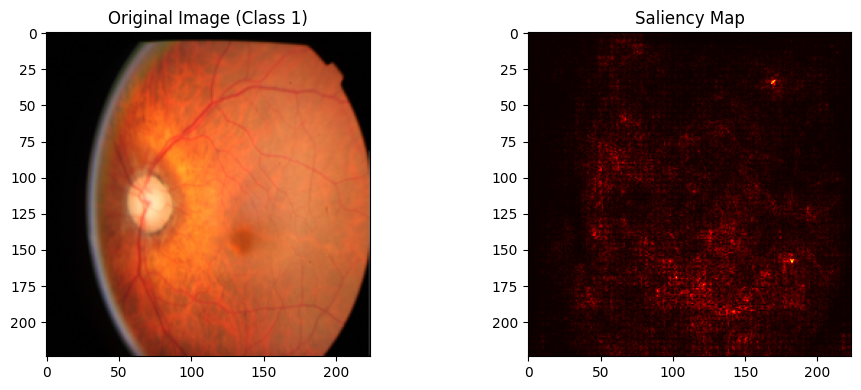

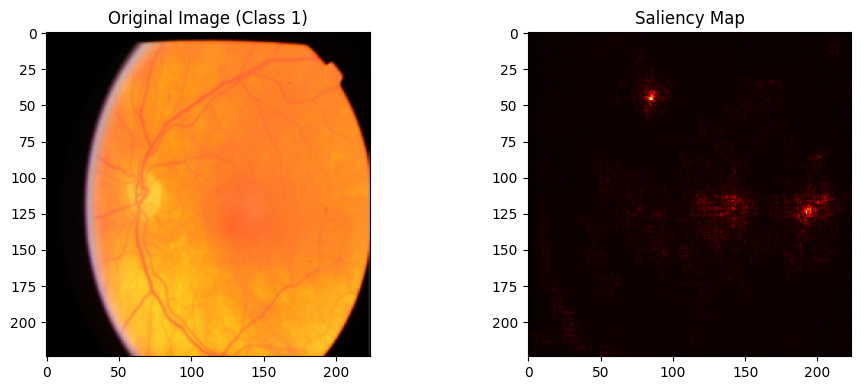

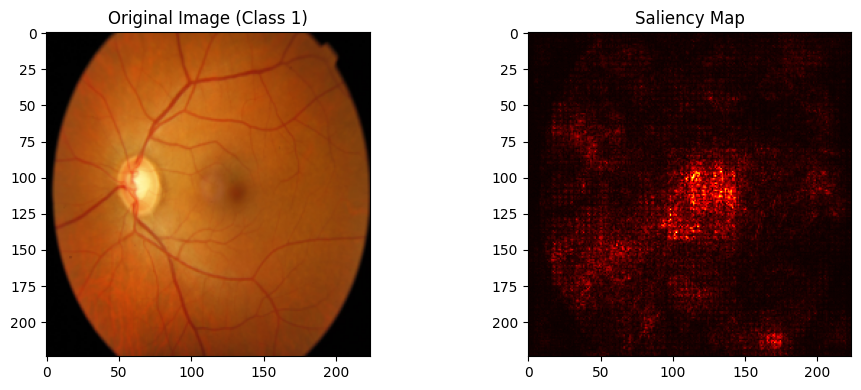

In [15]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 31/31 [00:09<00:00,  3.19it/s]


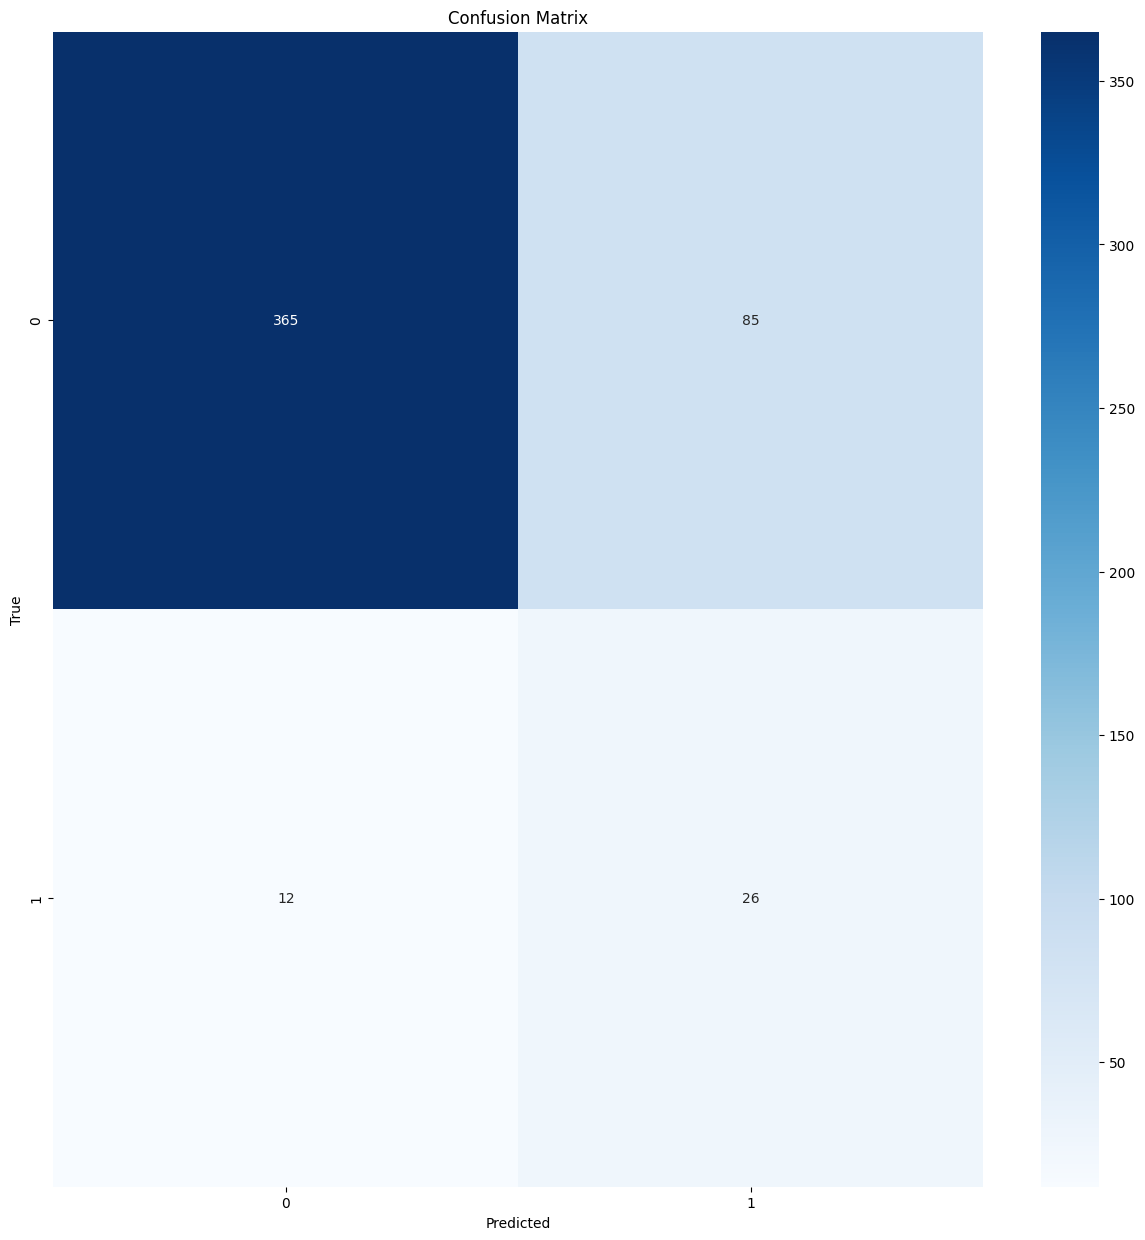

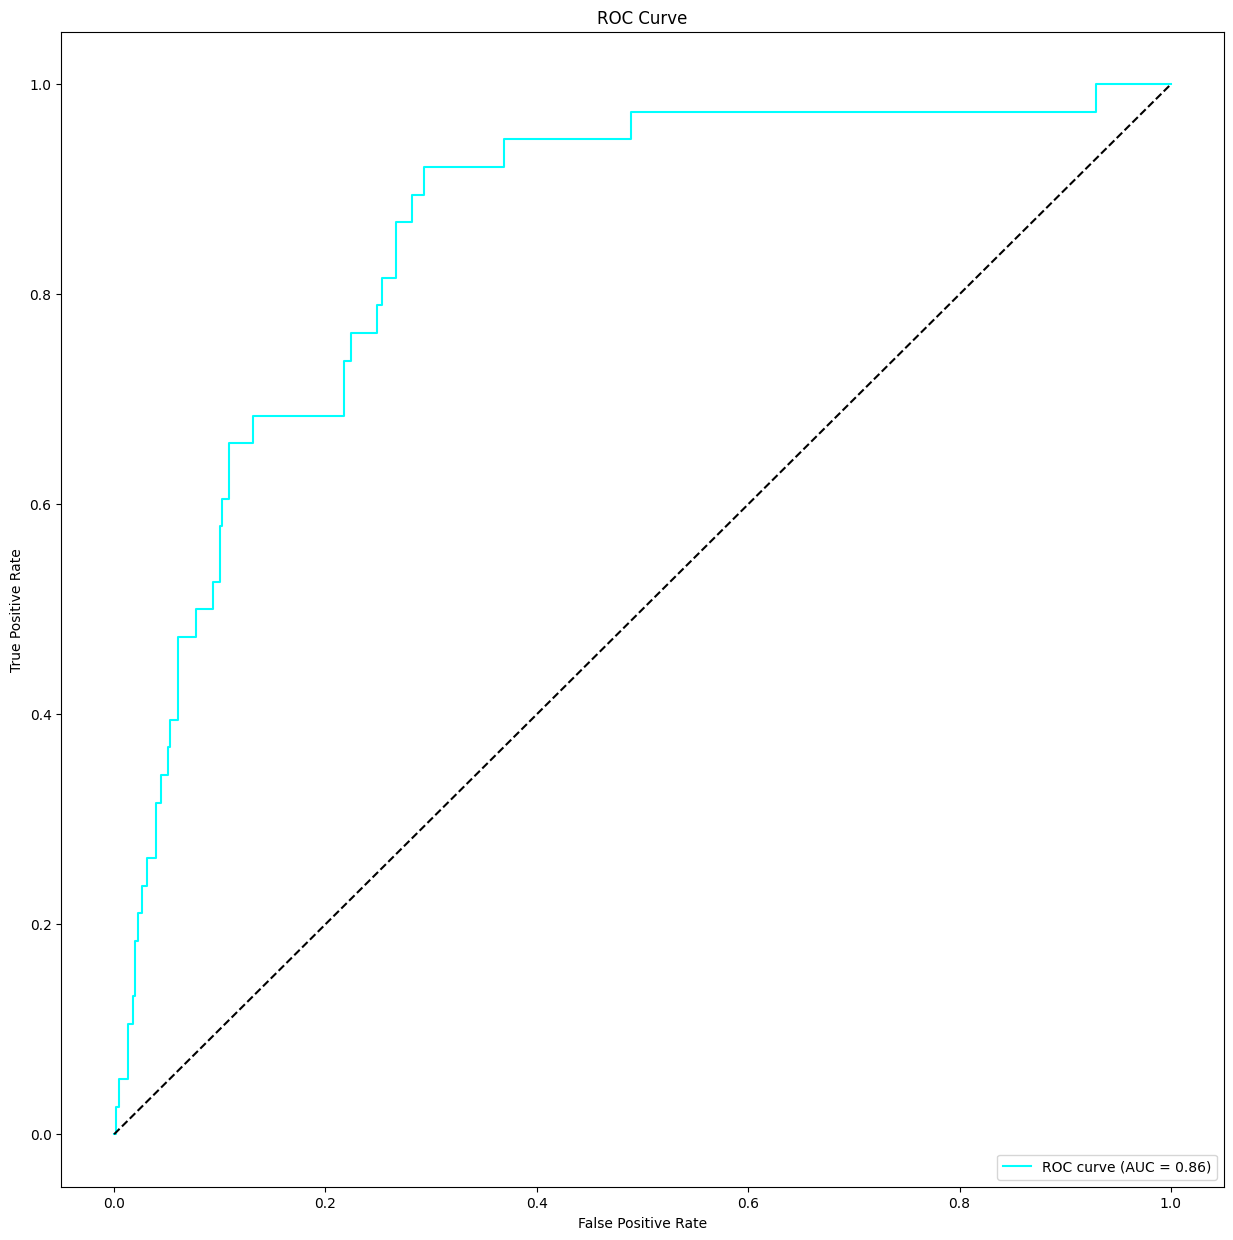

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       450
           1       0.23      0.68      0.35        38

    accuracy                           0.80       488
   macro avg       0.60      0.75      0.62       488
weighted avg       0.91      0.80      0.84       488

##################################################  Saliency Maps  ##################################################

Class 0:


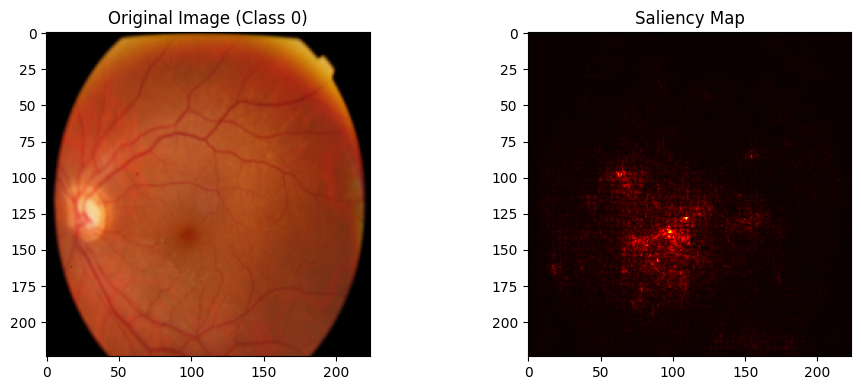

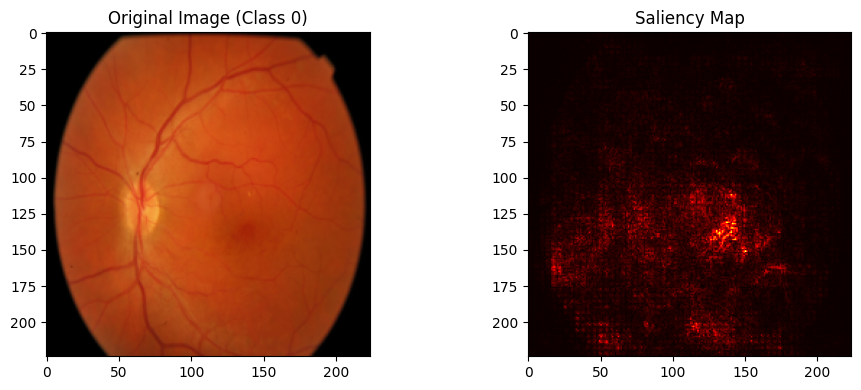

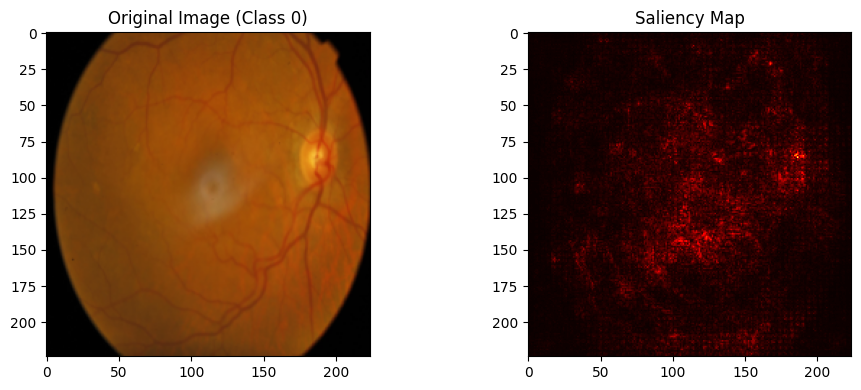

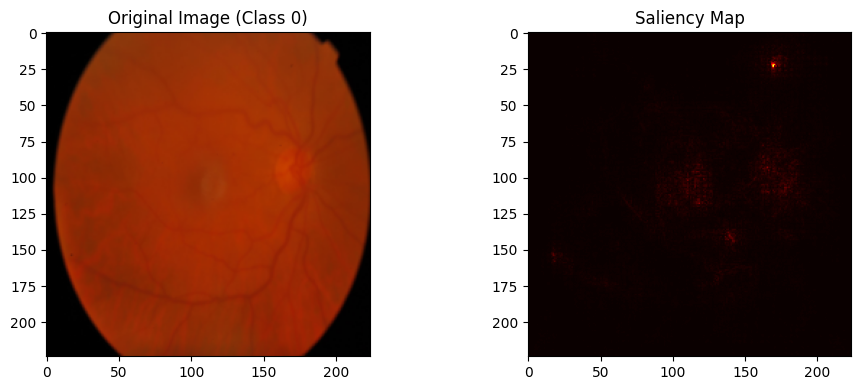

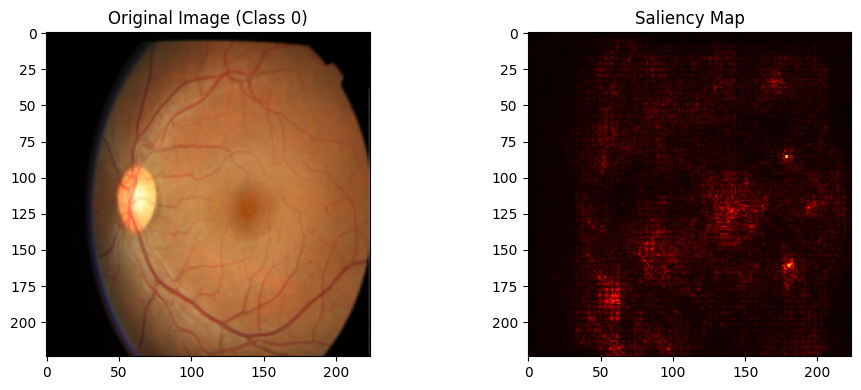

Class 1:


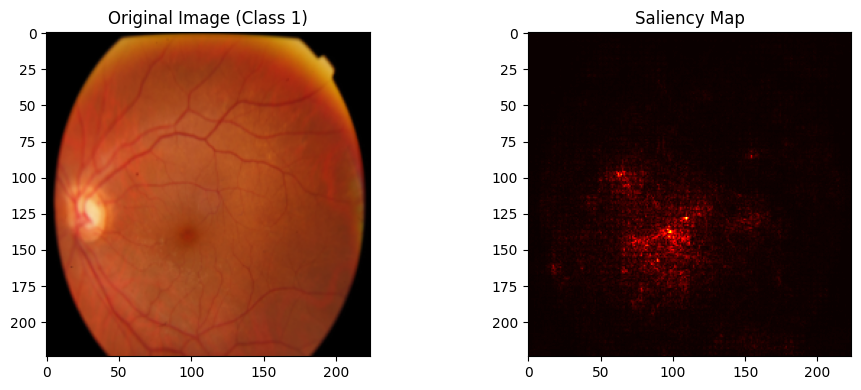

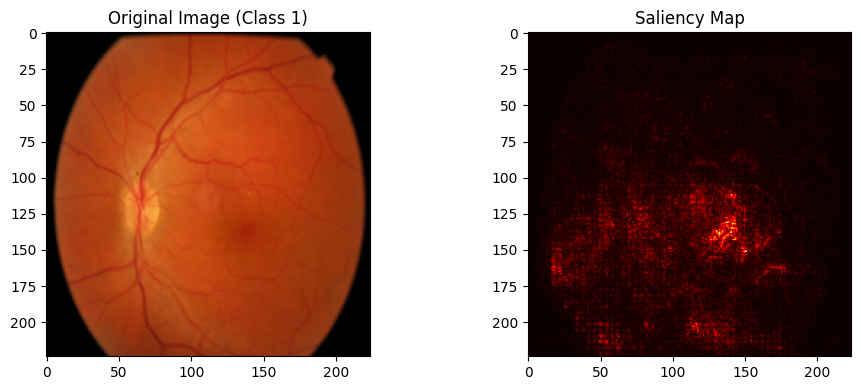

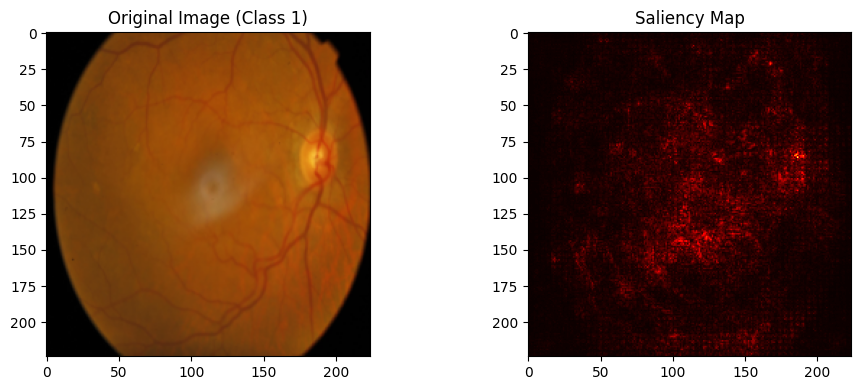

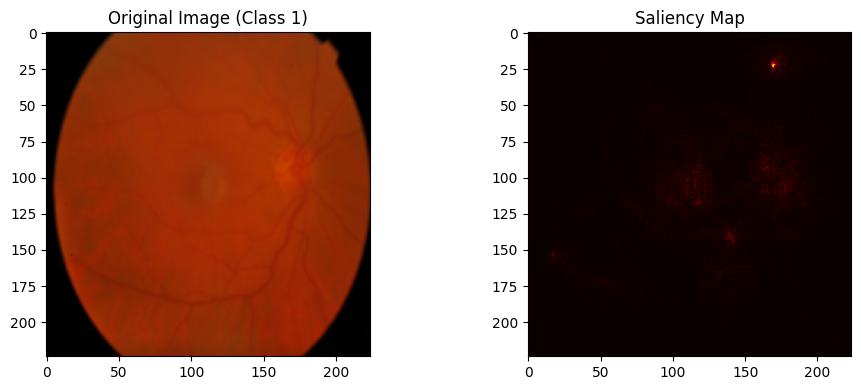

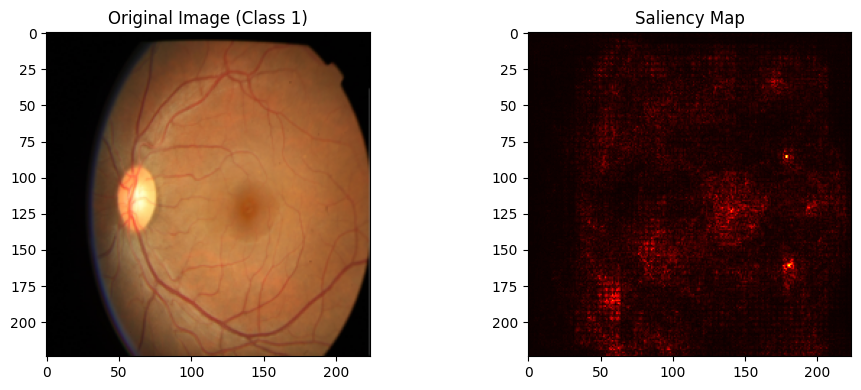

In [16]:
test(model, inadequate_dataloader, saliency=True, device=device)